In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [ ]:
'''
> Описание задания
А/А-тестирование мобильного приложения. Необходимо посчитать результаты A/A-теста, проверяя метрику качества FPR 
(будем проверять на конверсии в покупку). Известно, что сплит-система сломана. Требуется проверить утверждение о поломке
и найти ее причины, если сплит-система действительно сломана

Описание колонок
experimentVariant – вариант эксперимента
version – версия приложения
purchase – факт покупки
 

Задача
Запустите A/A-тест
Посчитайте FPR на уровне альфа = 0.05 (ставьте подвыборки без возвращения объемом 1000). Вы увидите, что FPR > альфа! 
Нам нужно наоборот – чтобы было меньше.
Найдите причины поломки сплит-системы, ориентируясь на результаты эксперимента (подсказка: найдите аномалию в версии приложения)
Напишите выводы, которые можно сделать на основе анализа результатов A/A-теста
'''

In [4]:
df = pd.read_csv('/Users/ruslanhuretski/Documents/karpov.courses/Statistics/hw_aa.csv', sep=';')

In [5]:
df.head()

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


In [6]:
df.dtypes

Unnamed: 0            int64
uid                  object
experimentVariant     int64
version              object
purchase              int64
dtype: object

In [7]:
df.shape

(127018, 5)

In [8]:
df.version.value_counts()

v2.8.0      82835
v2.9.0      23954
v3.8.0.0    11804
v3.7.4.0     8425
Name: version, dtype: int64

  0%|          | 0/1000 [00:00<?, ?it/s]

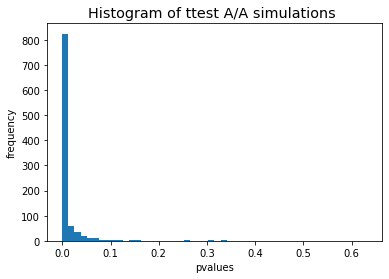

0.939

In [22]:
n = 100000
simulations = 1000
n_s = 1000
res = []

for i in tqdm(range(simulations)):
    s1 = df[df.experimentVariant == 1].purchase.sample(n_s, replace = False).values
    s2 = df[df.experimentVariant == 0].purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1])

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# FPR не сойдется
sum(np.array(res) < 0.05) / simulations

In [23]:
df.groupby('experimentVariant', as_index=False)\
    .agg({'purchase': 'mean'})

,experimentVariant,purchase
0,0,0.023945
1,1,0.053242


In [29]:
df.groupby('version', as_index=False)\
    .agg({'purchase': 'mean', 'Unnamed: 0': 'count'})

,version,purchase,Unnamed: 0
0,v2.8.0,0.023372,82835
1,v2.9.0,0.072973,23954
2,v3.7.4.0,0.061484,8425
3,v3.8.0.0,0.060319,11804


In [38]:
# Найдем процент пользователей v2.8.0
round(100*82835/df.shape[0], 2)

65.22

In [35]:
df.groupby(['experimentVariant', 'version'], as_index=False)\
    .agg({'purchase': 'mean', 'Unnamed: 0': 'count'}) \
    .round(4)

,experimentVariant,version,purchase,Unnamed: 0
0,0,v2.8.0,0.0010,41283
1,0,v2.9.0,0.0747,11921
2,0,v3.7.4.0,0.0599,4204
3,0,v3.8.0.0,0.0576,5694
4,1,v2.8.0,0.0456,41552
5,1,v2.9.0,0.0713,12033
6,1,v3.7.4.0,0.0630,4221
7,1,v3.8.0.0,0.0628,6110


  0%|          | 0/1000 [00:00<?, ?it/s]

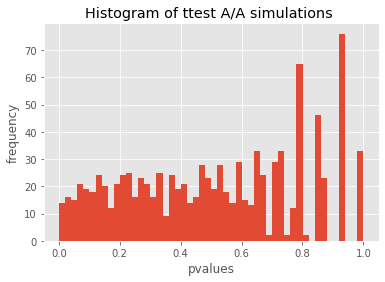

0.036

In [41]:
n = 100000
simulations = 1000
n_s = 1000
res = []

for i in tqdm(range(simulations)):
    s1 = df[(df.experimentVariant == 1) & (df.version != 'v2.8.0')].purchase.sample(n_s, replace = False).values
    s2 = df[(df.experimentVariant == 0) & (df.version != 'v2.8.0')].purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1])

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) < 0.05) / simulations

В экспериментальную группу 0 попадают такие пользователи версии приложения v2.8.0, у которых конверсия в покупку 0.1%. А в экспериментальную группу 1 попадают такие пользователи версии приложения v2.8.0, у которых конверсия в покупку 4.56% (в 40+ раз больше!). 
Общее их количество более 65%, что существенно влияет на наш эксперимент. 

Подозреваем, что система сплитования поломалась для пользователей версии приложения v2.8.0. Если исключим данную версию и повторно запустим расчет FPR через A/A, то теперь FPR < альфа. Мы доказали, что данные различия и портили результат нашего теста.